Учебное соревнование kaggle по классификации персонажей из Симпсонов.

https://www.kaggle.com/c/journey-springfield/overview


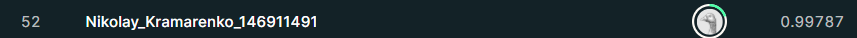

In [1]:
import PIL
import pickle
import numpy as np
from skimage import io
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import torch
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models
from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from os.path import exists

In [2]:
DEVICE = torch.device("cuda")

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

    
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False, pin_memory=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        opt = torch.optim.AdamW(model.parameters(), amsgrad=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

В конструкторе класса я переопределил загрузку картинок, добавив аугментацию.

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        self.len_ = len(self.files)     
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':            
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])        
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
train_val_dataset = SimpsonsDataset(train_val_files, mode='train')

Будем использовать Transfer Learning, в качестве предобученной модели возьмем resnet50.
Оставим размороженными последние 2 слоя.

In [13]:
n_classes = len(np.unique(train_val_labels))
model = models.resnet50(pretrained=True).to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(model)

we will classify :42


In [14]:
# замораживаем веса всех слоев
for param in model.parameters():
    param.requires_grad = False
# размораживаем 2 последних слоя
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, n_classes).to(DEVICE)

Модель обучалась сетами по 10-20 эпох, затем веса сохранялись и модель доучивалась.
На выводе обучения модели видны последние 10 эпох обучения 60-70. Для воспроизводимости можно запустить модель с 60 или 70 эпохами, результат на каггле был идентичен.

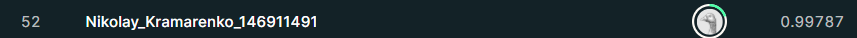

In [44]:
history = train(train_val_dataset, val_dataset, model=model, epochs=10, batch_size=32)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 0.054849769383687054


epoch:  10%|███████▌                                                                   | 1/10 [03:12<28:53, 192.61s/it]


Epoch 001 train_loss: 0.0548     val_loss 0.0198 train_acc 0.9843 val_acc 0.9950
loss 0.049049857777005317


epoch:  20%|███████████████                                                            | 2/10 [06:24<25:38, 192.26s/it]


Epoch 002 train_loss: 0.0490     val_loss 0.0234 train_acc 0.9858 val_acc 0.9929
loss 0.03918733602132279


epoch:  30%|██████████████████████▌                                                    | 3/10 [09:34<22:22, 191.82s/it]


Epoch 003 train_loss: 0.0392     val_loss 0.0291 train_acc 0.9894 val_acc 0.9918
loss 0.029496085015709165


epoch:  40%|██████████████████████████████                                             | 4/10 [12:45<19:09, 191.61s/it]


Epoch 004 train_loss: 0.0295     val_loss 0.0173 train_acc 0.9908 val_acc 0.9960
loss 0.04007536094219743


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [15:58<15:59, 191.85s/it]


Epoch 005 train_loss: 0.0401     val_loss 0.0525 train_acc 0.9882 val_acc 0.9868
loss 0.04273248182370996


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [19:52<13:38, 204.63s/it]


Epoch 006 train_loss: 0.0427     val_loss 0.0587 train_acc 0.9876 val_acc 0.9822
loss 0.03389413569507886


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [23:30<10:25, 208.59s/it]


Epoch 007 train_loss: 0.0339     val_loss 0.0082 train_acc 0.9906 val_acc 0.9981
loss 0.020292498155344344


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [26:53<06:53, 206.88s/it]


Epoch 008 train_loss: 0.0203     val_loss 0.0064 train_acc 0.9935 val_acc 0.9979
loss 0.04187874787322372


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [30:15<03:25, 205.52s/it]


Epoch 009 train_loss: 0.0419     val_loss 0.0103 train_acc 0.9881 val_acc 0.9969
loss 0.02175431690847115


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [33:31<00:00, 201.10s/it]


Epoch 010 train_loss: 0.0218     val_loss 0.0161 train_acc 0.9939 val_acc 0.9958


In [45]:
# save model
torch.save(model.state_dict(), "./_models/resnet50_2_70epoche_weights.pth") 

In [38]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = list(y_pred)
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'ID': test_filenames, 'Expected': preds})
my_submit.to_csv('./_answers/resnet50_2_70.csv', index=False)